In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, ParameterGrid
import multiprocessing
import warnings
import sklearn
print(sklearn.__version__) 

1.0.1


In [8]:
df = pd.read_csv("../results/results_SmallFog_X/samples.csv")
df.head()

,sim,app,currentFlavour,action,HWreq,OdiffReqChannels,OreqChannels,OsumReq,OavgReq,OsumLat,...,FavgReq,FsumLat,FavgLat,FHWtotal,FHWfree,Futilization,Fdegree,Fcentrality,Fnusers,fit
0,0,1,medium,undeploy,10,1,1,2,2.0,4,...,0.0,0,0.0,2.0,0,1.000000,1,0.076923,1,0.0
1,0,1,medium,small,10,1,1,3,3.0,4,...,1.0,4,4.0,2.0,1,0.500000,1,0.076923,1,1.0
2,0,1,medium,large,10,1,1,1,1.0,4,...,2.0,4,4.0,2.0,-3,2.500000,1,0.076923,1,0.0
3,0,1,small,undeploy,5,1,1,2,2.0,7,...,0.0,0,0.0,6.0,4,0.333333,4,0.307692,1,0.0
4,0,1,small,replicate,5,1,1,1,1.0,7,...,0.0,0,0.0,6.0,4,0.333333,4,0.307692,1,1.0


In [11]:
#dummies
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]
actions = np.arange(len(actions_labels)) #dummies
print(actions)
df["action"] = df["action"].map(lambda x:actions_labels.index(x))
df["currentFlavour"] = df["currentFlavour"].map(lambda x:actions_labels.index(x))

[0 1 2 3 4 5]


In [12]:
df.head()

,sim,app,currentFlavour,action,HWreq,OdiffReqChannels,OreqChannels,OsumReq,OavgReq,OsumLat,...,FavgReq,FsumLat,FavgLat,FHWtotal,FHWfree,Futilization,Fdegree,Fcentrality,Fnusers,fit
0,0,1,2,0,10,1,1,2,2.0,4,...,0.0,0,0.0,2.0,0,1.000000,1,0.076923,1,0.0
1,0,1,2,1,10,1,1,3,3.0,4,...,1.0,4,4.0,2.0,1,0.500000,1,0.076923,1,1.0
2,0,1,2,3,10,1,1,1,1.0,4,...,2.0,4,4.0,2.0,-3,2.500000,1,0.076923,1,0.0
3,0,1,1,0,5,1,1,2,2.0,7,...,0.0,0,0.0,6.0,4,0.333333,4,0.307692,1,0.0
4,0,1,1,5,5,1,1,1,1.0,7,...,0.0,0,0.0,6.0,4,0.333333,4,0.307692,1,1.0


In [20]:
df = df.drop(columns="sim")

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = "fit"),
                                        df['fit'],
                                        random_state = 0)
print(len(X_train))
print(len(X_test))

762
254


In [22]:
#Training                                    
model = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=123)

In [23]:
importancia_predictores = pd.DataFrame(
                            {'predictor': df.drop(columns = "fit").columns,
                             'importancia': model.feature_importances_}
                            )

importancia_predictores.sort_values('importancia', ascending=False)


,predictor,importancia
2,action,0.363508
6,OsumReq,0.135895
4,OdiffReqChannels,0.102897
19,FsumReq,0.093892
24,FHWfree,0.074632
25,Futilization,0.068993
7,OavgReq,0.037690
20,FavgReq,0.029742
8,OsumLat,0.016719
9,OavgLat,0.014760


In [24]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = model,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
2,0.447943,0.010538,action
19,0.230267,0.007588,FsumReq
6,0.184897,0.004324,OsumReq
4,0.121047,0.003329,OdiffReqChannels
25,0.108122,0.004176,Futilization
24,0.104100,0.002514,FHWfree
20,0.074651,0.003409,FavgReq
7,0.067971,0.002049,OavgReq
8,0.051600,0.001355,OsumLat
9,0.043748,0.005071,OavgLat


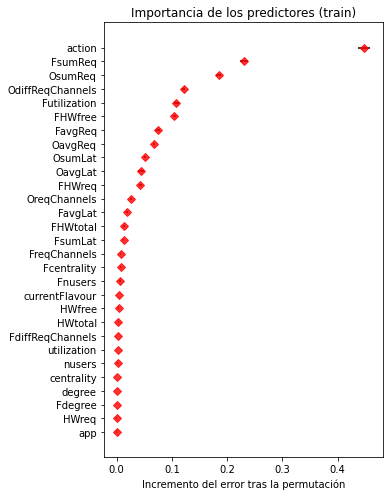

In [25]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 8))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

In [27]:
# Sample one
df.columns

Index(['app', 'currentFlavour', 'action', 'HWreq', 'OdiffReqChannels',
       'OreqChannels', 'OsumReq', 'OavgReq', 'OsumLat', 'OavgLat', 'HWtotal',
       'HWfree', 'utilization', 'degree', 'centrality', 'nusers', 'FHWreq',
       'FdiffReqChannels', 'FreqChannels', 'FsumReq', 'FavgReq', 'FsumLat',
       'FavgLat', 'FHWtotal', 'FHWfree', 'Futilization', 'Fdegree',
       'Fcentrality', 'Fnusers', 'fit'],
      dtype='object')

In [40]:
actions_labels = ["undeploy","small","medium","large","migrate","replicate"]
sampleO = [1,actions_labels.index("small"),actions_labels.index("undeploy"),1,1,1,10,10,3,3,4,2,0.5,1,0.09,0]
sampleF = [0,0,0,0,0,0,0,0,4,0,1,0.9,0]
fact = sampleO+sampleF
print(fact)
print(len(fact))
col = df.columns[:-1]
print(len(col))
dftest = pd.DataFrame(columns=list(col))
dftest.loc[0]=fact
dftest.head()

[1, 1, 0, 1, 1, 1, 10, 10, 3, 3, 4, 2, 0.5, 1, 0.09, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 0.9, 0]
29
29


,app,currentFlavour,action,HWreq,OdiffReqChannels,OreqChannels,OsumReq,OavgReq,OsumLat,OavgLat,...,FsumReq,FavgReq,FsumLat,FavgLat,FHWtotal,FHWfree,Futilization,Fdegree,Fcentrality,Fnusers
0,1.0,1.0,0.0,1.0,1.0,1.0,10.0,10.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.9,0.0


In [41]:
forecasting = model.predict(X = dftest)

In [42]:
print(forecasting)

[0.]
